合并实验结果

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

# 定义函数加载模型评估结果
def load_results(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

# 输入四个数据集的评估结果路径
def compare_model_results(real_path, stitched_path, tts_path, clone_path):
    # 加载四个数据集的评估结果
    real_results = load_results(real_path + "/result.json")
    stitched_results = load_results(stitched_path + "/result.json")
    tts_results = load_results(tts_path + "/result.json")
    clone_results = load_results(clone_path + "/result.json")
    
    # 定义模型名称和对应颜色
    models = {
        'real': {'results': real_results, 'color': 'blue'},
        'stitched': {'results': stitched_results, 'color': 'orange'},
        'tts': {'results': tts_results, 'color': 'green'},
        'clone': {'results': clone_results, 'color': 'red'}
    }
    
    # 1. 绘制PR曲线对比
    plt.figure(figsize=(10, 8))
    for model_name, model_info in models.items():
        precision = np.array(model_info['results']['pr_curve']['precision'])
        recall = np.array(model_info['results']['pr_curve']['recall'])
        aucpr = model_info['results']['summary']['aucpr']
        plt.plot(recall, precision, color=model_info['color'], 
                 label=f'{model_name} (AUCPR={aucpr:.4f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 2. 绘制FRR-FAPH曲线对比
    plt.figure(figsize=(10, 8))
    for model_name, model_info in models.items():
        frr = np.array(model_info['results']['frr_faph_curve']['frr'])
        faph = np.array(model_info['results']['frr_faph_curve']['faph'])
        
        # 排序以便绘图
        sorted_indices = np.argsort(faph)
        sorted_faph = faph[sorted_indices]
        sorted_frr = frr[sorted_indices]
        
        plt.plot(sorted_faph, sorted_frr, color=model_info['color'], marker='.', 
                 label=model_name)
    
    plt.xlabel('False Alarm Per Hour (FAPH)')
    plt.ylabel('False Rejection Rate (FRR)')
    plt.title('FRR vs FAPH Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 3. 绘制聚焦FRR-FAPH曲线对比 (FAPH <= 200)
    plt.figure(figsize=(10, 8))
    focus_limit = 200
    
    for model_name, model_info in models.items():
        frr = np.array(model_info['results']['frr_faph_curve']['frr'])
        faph = np.array(model_info['results']['frr_faph_curve']['faph'])
        
        # 排序以便绘图
        sorted_indices = np.argsort(faph)
        sorted_faph = faph[sorted_indices]
        sorted_frr = frr[sorted_indices]
        
        # 聚焦区域
        focus_indices = [i for i, v in enumerate(sorted_faph) if v <= focus_limit]
        if focus_indices:
            focus_faph = sorted_faph[focus_indices]
            focus_frr = sorted_frr[focus_indices]
            plt.plot(focus_faph, focus_frr, color=model_info['color'], marker='.', 
                     label=model_name)
    
    plt.xlabel('False Alarm Per Hour (FAPH)')
    plt.ylabel('False Rejection Rate (FRR)')
    plt.title(f'FRR vs FAPH Curves Comparison (FAPH ≤ {focus_limit})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 4. 模型指标对比表格
    summary_metrics = {
        'Model': [],
        'AUCPR': [],
        'Best F1 Score': [],
        'Best F1 Threshold': [],
        'Negative Test Hours': [],
        'Positive Samples': [],
        'Negative Samples': []
    }
    
    for model_name, model_info in models.items():
        summary = model_info['results']['summary']
        summary_metrics['Model'].append(model_name)
        summary_metrics['AUCPR'].append(summary['aucpr'])
        summary_metrics['Best F1 Score'].append(summary['best_f1_score'])
        summary_metrics['Best F1 Threshold'].append(summary['best_f1_threshold'])
        summary_metrics['Negative Test Hours'].append(summary['negative_test_duration_hours'])
        summary_metrics['Positive Samples'].append(summary['num_positive_samples_test'])
        summary_metrics['Negative Samples'].append(summary['num_negative_samples_test'])
    
    summary_df = pd.DataFrame(summary_metrics)
    display(Markdown("### 模型整体指标对比"))
    display(summary_df)
    
    # 5. 特定阈值下的指标对比
    # 选择几个常用阈值
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    
    for threshold in thresholds:
        threshold_metrics = {
            'Model': [],
            'Threshold': [],
            'Precision': [],
            'Recall': [],
            'F1 Score': [],
            'FRR': [],
            'FAPH': []
        }
        
        for model_name, model_info in models.items():
            # 找到最接近该阈值的指标
            metrics_list = model_info['results']['metrics_per_threshold']
            closest_metric = min(metrics_list, key=lambda x: abs(x['threshold'] - threshold))
            
            threshold_metrics['Model'].append(model_name)
            threshold_metrics['Threshold'].append(closest_metric['threshold'])
            threshold_metrics['Precision'].append(closest_metric['precision'])
            threshold_metrics['Recall'].append(closest_metric['recall'])
            threshold_metrics['F1 Score'].append(closest_metric['f1_score'])
            threshold_metrics['FRR'].append(closest_metric['frr'])
            threshold_metrics['FAPH'].append(closest_metric['faph'])
        
        threshold_df = pd.DataFrame(threshold_metrics)
        display(Markdown(f"### 阈值 ≈ {threshold} 的模型指标对比"))
        display(threshold_df)
    
    # 6. 新增表格1：AUCPR、Best F1 Score和Best F1 Threshold比较
    display(Markdown("### 模型核心性能指标对比"))
    core_metrics = {
        'Model': [],
        'AUCPR': [],
        'Best F1 Score': [],
        'Best F1 Threshold': []
    }
    
    for model_name, model_info in models.items():
        summary = model_info['results']['summary']
        core_metrics['Model'].append(model_name)
        core_metrics['AUCPR'].append(summary['aucpr'])
        core_metrics['Best F1 Score'].append(summary['best_f1_score'])
        core_metrics['Best F1 Threshold'].append(summary['best_f1_threshold'])
    
    core_metrics_df = pd.DataFrame(core_metrics)
    display(core_metrics_df)
    
    # 7. 新增表格2：不同阈值下的F1 Score对比
    display(Markdown("### 不同阈值下F1 Score对比"))
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    f1_comparison = {'Model': [model_name for model_name in models.keys()]}
    
    # 为每个阈值创建一列
    for threshold in thresholds:
        f1_comparison[f'F1@{threshold}'] = []
        
    # 填充每个模型在每个阈值下的F1值
    for model_name, model_info in models.items():
        metrics_list = model_info['results']['metrics_per_threshold']
        for threshold in thresholds:
            # 找到最接近该阈值的指标
            closest_metric = min(metrics_list, key=lambda x: abs(x['threshold'] - threshold))
            f1_comparison[f'F1@{threshold}'].append(closest_metric['f1_score'])
    
    f1_comparison_df = pd.DataFrame(f1_comparison)
    display(f1_comparison_df)
    
    return {
        'models': models,
        'summary_metrics': summary_df,
        'threshold_metrics': threshold_df  # 只保存最后一个阈值的结果
    }

# 使用示例
# compare_model_results(
#     'path/to/real_workspace/test',
#     'path/to/stitched_workspace/test',
#     'path/to/tts_workspace/test',
#     'path/to/clone_workspace/test'
# )

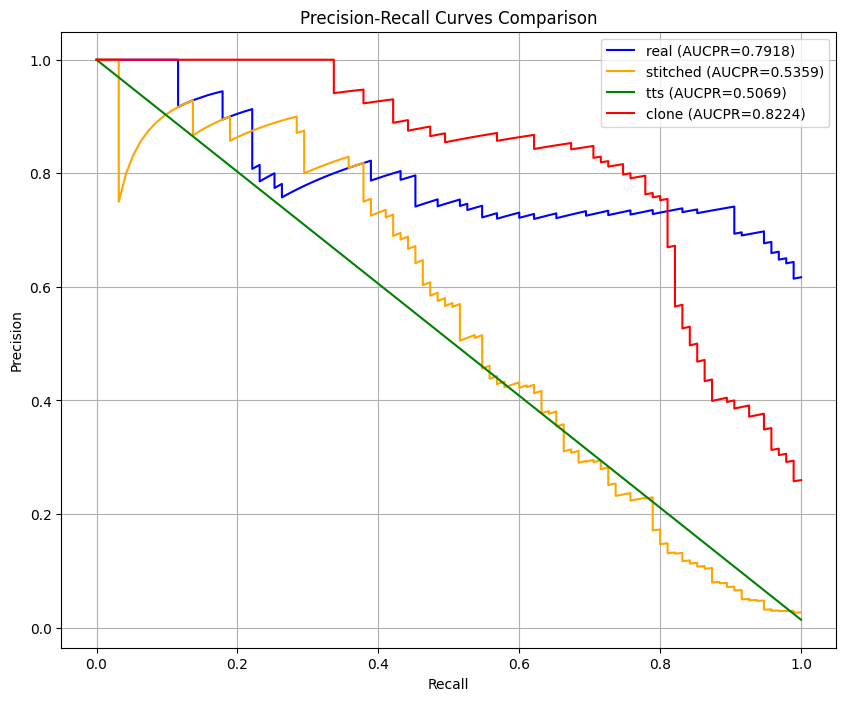

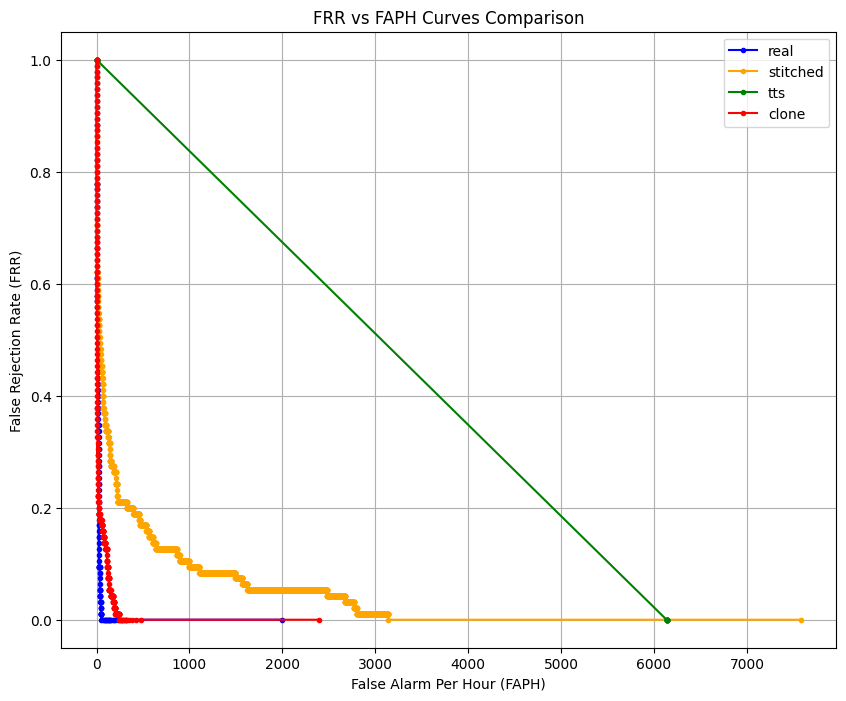

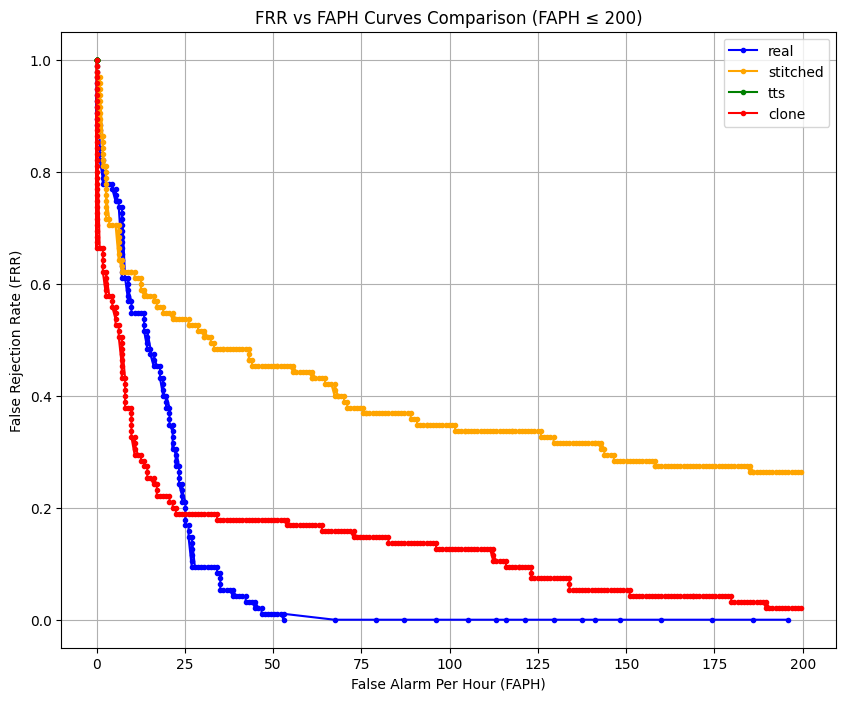

### 模型整体指标对比

,Model,AUCPR,Best F1 Score,Best F1 Threshold,Negative Test Hours,Positive Samples,Negative Samples
0,real,0.791797,0.815166,0.996221,1.112572,95,2225
1,stitched,0.535936,0.541436,0.785145,1.112572,95,8436
2,tts,0.506863,0.027081,0.000000,1.112572,95,6826
3,clone,0.822370,0.787234,0.992749,1.112572,95,2667


### 阈值 ≈ 0.5 的模型指标对比

,Model,Threshold,Precision,Recall,F1 Score,FRR,FAPH
0,real,0.5,0.383065,1.000000,0.553936,0.000000,137.519162
1,stitched,0.5,0.413793,0.631579,0.500000,0.368421,76.399535
2,tts,0.5,0.000000,0.000000,0.000000,1.000000,0.000000
3,clone,0.5,0.235149,1.000000,0.380762,0.000000,277.734779


### 阈值 ≈ 0.6 的模型指标对比

,Model,Threshold,Precision,Recall,F1 Score,FRR,FAPH
0,real,0.6,0.413043,1.000000,0.584615,0.000000,121.340437
1,stitched,0.6,0.442623,0.568421,0.497696,0.431579,61.119628
2,tts,0.6,0.000000,0.000000,0.000000,1.000000,0.000000
3,clone,0.6,0.245478,1.000000,0.394191,0.000000,262.454872


### 阈值 ≈ 0.7 的模型指标对比

,Model,Threshold,Precision,Recall,F1 Score,FRR,FAPH
0,real,0.7,0.429864,1.000000,0.601266,0.000000,113.251075
1,stitched,0.7,0.515152,0.536842,0.525773,0.463158,43.143267
2,tts,0.7,0.000000,0.000000,0.000000,1.000000,0.000000
3,clone,0.7,0.258953,0.989474,0.410480,0.010526,241.782057


### 阈值 ≈ 0.8 的模型指标对比

,Model,Threshold,Precision,Recall,F1 Score,FRR,FAPH
0,real,0.8,0.470297,1.000000,0.639731,0.000000,96.173532
1,stitched,0.8,0.580247,0.494737,0.534091,0.505263,30.559814
2,tts,0.8,0.000000,0.000000,0.000000,1.000000,0.000000
3,clone,0.8,0.278932,0.989474,0.435185,0.010526,218.412787


### 阈值 ≈ 0.9 的模型指标对比

,Model,Threshold,Precision,Recall,F1 Score,FRR,FAPH
0,real,0.9,0.519126,1.000000,0.683453,0.000000,79.095989
1,stitched,0.9,0.688525,0.442105,0.538462,0.557895,17.077543
2,tts,0.9,0.000000,0.000000,0.000000,1.000000,0.000000
3,clone,0.9,0.326165,0.957895,0.486631,0.042105,168.977794


### 模型核心性能指标对比

,Model,AUCPR,Best F1 Score,Best F1 Threshold
0,real,0.791797,0.815166,0.996221
1,stitched,0.535936,0.541436,0.785145
2,tts,0.506863,0.027081,0.000000
3,clone,0.822370,0.787234,0.992749


### 不同阈值下F1 Score对比

,Model,F1@0.5,F1@0.6,F1@0.7,F1@0.8,F1@0.9
0,real,0.553936,0.584615,0.601266,0.639731,0.683453
1,stitched,0.500000,0.497696,0.525773,0.534091,0.538462
2,tts,0.000000,0.000000,0.000000,0.000000,0.000000
3,clone,0.380762,0.394191,0.410480,0.435185,0.486631


In [4]:
results = compare_model_results(
    'E:/CODE/git_repositories/bcresnet/workspace/merge_test_results/real_442_test',
    'E:/CODE/git_repositories/bcresnet/workspace/merge_test_results/stitched_442_test',
    'E:/CODE/git_repositories/bcresnet/workspace/merge_test_results/tts_442_test',
    'E:/CODE/git_repositories/bcresnet/workspace/merge_test_results/clone_442_test'
)

合并消融实验结果

In [5]:
# 定义函数合并消融实验结果
def compare_ablation_results(clone_path, clone_without_amp_path):
    # 加载两个数据集的评估结果
    clone_results = load_results(clone_path + "/result.json")
    clone_without_amp_results = load_results(clone_without_amp_path + "/result.json")
    
    # 定义模型名称和对应颜色
    models = {
        'clone': {'results': clone_results, 'color': 'blue'},
        'clone_without_amp': {'results': clone_without_amp_results, 'color': 'red'}
    }
    
    # 1. 绘制PR曲线对比
    plt.figure(figsize=(10, 8))
    for model_name, model_info in models.items():
        precision = np.array(model_info['results']['pr_curve']['precision'])
        recall = np.array(model_info['results']['pr_curve']['recall'])
        aucpr = model_info['results']['summary']['aucpr']
        plt.plot(recall, precision, color=model_info['color'], 
                 label=f'{model_name} (AUCPR={aucpr:.4f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 2. 绘制FRR-FAPH曲线对比
    plt.figure(figsize=(10, 8))
    for model_name, model_info in models.items():
        frr = np.array(model_info['results']['frr_faph_curve']['frr'])
        faph = np.array(model_info['results']['frr_faph_curve']['faph'])
        
        # 排序以便绘图
        sorted_indices = np.argsort(faph)
        sorted_faph = faph[sorted_indices]
        sorted_frr = frr[sorted_indices]
        
        plt.plot(sorted_faph, sorted_frr, color=model_info['color'], marker='.', 
                 label=model_name)
    
    plt.xlabel('False Alarm Per Hour (FAPH)')
    plt.ylabel('False Rejection Rate (FRR)')
    plt.title('FRR vs FAPH Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 3. 绘制聚焦FRR-FAPH曲线对比 (FAPH <= 200)
    plt.figure(figsize=(10, 8))
    focus_limit = 200
    
    for model_name, model_info in models.items():
        frr = np.array(model_info['results']['frr_faph_curve']['frr'])
        faph = np.array(model_info['results']['frr_faph_curve']['faph'])
        
        # 排序以便绘图
        sorted_indices = np.argsort(faph)
        sorted_faph = faph[sorted_indices]
        sorted_frr = frr[sorted_indices]
        
        # 聚焦区域
        focus_indices = [i for i, v in enumerate(sorted_faph) if v <= focus_limit]
        if focus_indices:
            focus_faph = sorted_faph[focus_indices]
            focus_frr = sorted_frr[focus_indices]
            plt.plot(focus_faph, focus_frr, color=model_info['color'], marker='.', 
                     label=model_name)
    
    plt.xlabel('False Alarm Per Hour (FAPH)')
    plt.ylabel('False Rejection Rate (FRR)')
    plt.title(f'FRR vs FAPH Curves Comparison (FAPH ≤ {focus_limit})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 4. 模型指标对比表格
    summary_metrics = {
        'Model': [],
        'AUCPR': [],
        'Best F1 Score': [],
        'Best F1 Threshold': [],
        'Negative Test Hours': [],
        'Positive Samples': [],
        'Negative Samples': []
    }
    
    for model_name, model_info in models.items():
        summary = model_info['results']['summary']
        summary_metrics['Model'].append(model_name)
        summary_metrics['AUCPR'].append(summary['aucpr'])
        summary_metrics['Best F1 Score'].append(summary['best_f1_score'])
        summary_metrics['Best F1 Threshold'].append(summary['best_f1_threshold'])
        summary_metrics['Negative Test Hours'].append(summary['negative_test_duration_hours'])
        summary_metrics['Positive Samples'].append(summary['num_positive_samples_test'])
        summary_metrics['Negative Samples'].append(summary['num_negative_samples_test'])
    
    summary_df = pd.DataFrame(summary_metrics)
    display(Markdown("### 模型整体指标对比"))
    display(summary_df)
    
    # 5. 特定阈值下的指标对比
    # 选择几个常用阈值
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    
    for threshold in thresholds:
        threshold_metrics = {
            'Model': [],
            'Threshold': [],
            'Precision': [],
            'Recall': [],
            'F1 Score': [],
            'FRR': [],
            'FAPH': []
        }
        
        for model_name, model_info in models.items():
            # 找到最接近该阈值的指标
            metrics_list = model_info['results']['metrics_per_threshold']
            closest_metric = min(metrics_list, key=lambda x: abs(x['threshold'] - threshold))
            
            threshold_metrics['Model'].append(model_name)
            threshold_metrics['Threshold'].append(closest_metric['threshold'])
            threshold_metrics['Precision'].append(closest_metric['precision'])
            threshold_metrics['Recall'].append(closest_metric['recall'])
            threshold_metrics['F1 Score'].append(closest_metric['f1_score'])
            threshold_metrics['FRR'].append(closest_metric['frr'])
            threshold_metrics['FAPH'].append(closest_metric['faph'])
        
        threshold_df = pd.DataFrame(threshold_metrics)
        display(Markdown(f"### 阈值 ≈ {threshold} 的模型指标对比"))
        display(threshold_df)
    
    # 6. 新增表格1：AUCPR、Best F1 Score和Best F1 Threshold比较
    display(Markdown("### 模型核心性能指标对比"))
    core_metrics = {
        'Model': [],
        'AUCPR': [],
        'Best F1 Score': [],
        'Best F1 Threshold': []
    }
    
    for model_name, model_info in models.items():
        summary = model_info['results']['summary']
        core_metrics['Model'].append(model_name)
        core_metrics['AUCPR'].append(summary['aucpr'])
        core_metrics['Best F1 Score'].append(summary['best_f1_score'])
        core_metrics['Best F1 Threshold'].append(summary['best_f1_threshold'])
    
    core_metrics_df = pd.DataFrame(core_metrics)
    display(core_metrics_df)
    
    # 7. 新增表格2：不同阈值下的F1 Score对比
    display(Markdown("### 不同阈值下F1 Score对比"))
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    f1_comparison = {'Model': [model_name for model_name in models.keys()]}
    
    # 为每个阈值创建一列
    for threshold in thresholds:
        f1_comparison[f'F1@{threshold}'] = []
        
    # 填充每个模型在每个阈值下的F1值
    for model_name, model_info in models.items():
        metrics_list = model_info['results']['metrics_per_threshold']
        for threshold in thresholds:
            # 找到最接近该阈值的指标
            closest_metric = min(metrics_list, key=lambda x: abs(x['threshold'] - threshold))
            f1_comparison[f'F1@{threshold}'].append(closest_metric['f1_score'])
    
    f1_comparison_df = pd.DataFrame(f1_comparison)
    display(f1_comparison_df)
    
    return {
        'models': models,
        'summary_metrics': summary_df,
        'threshold_metrics': threshold_df  # 只保存最后一个阈值的结果
    }

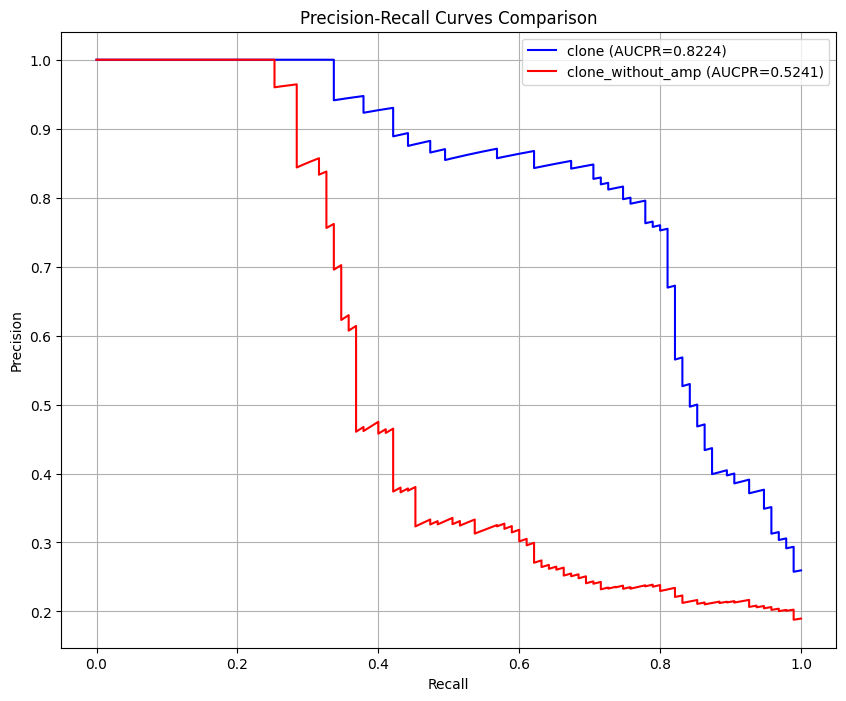

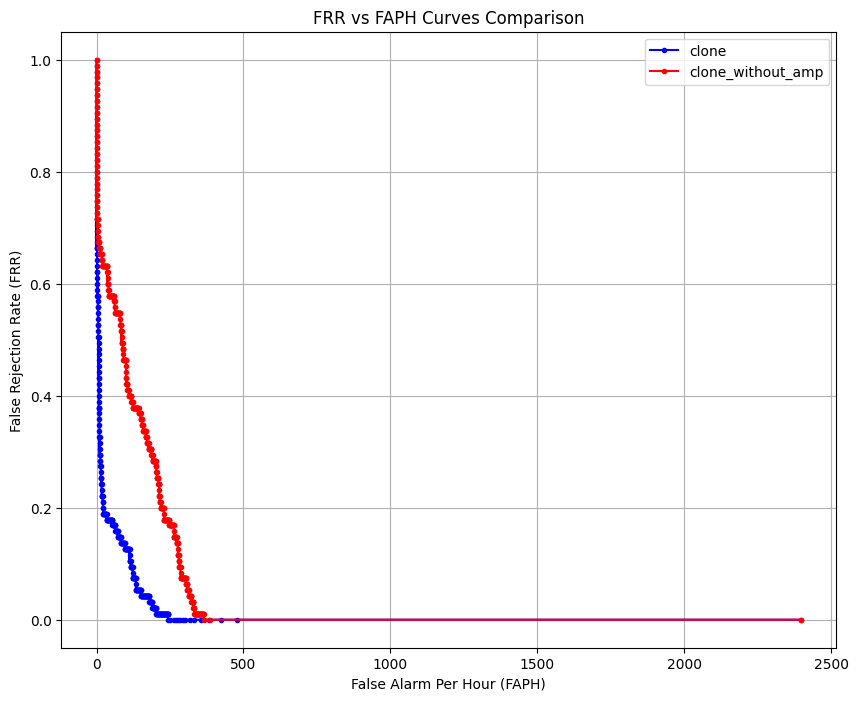

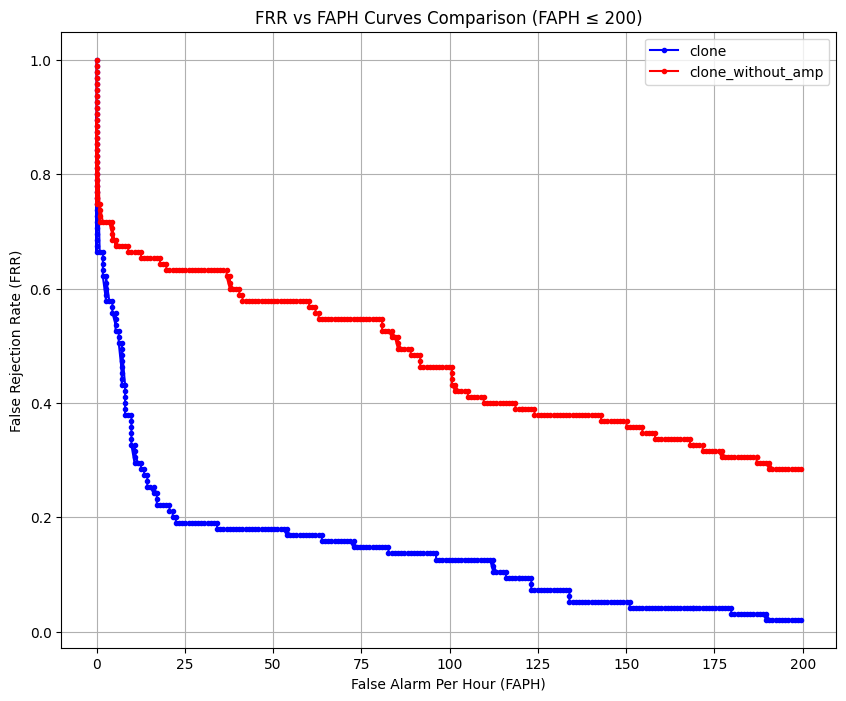

### 模型整体指标对比

,Model,AUCPR,Best F1 Score,Best F1 Threshold,Negative Test Hours,Positive Samples,Negative Samples
0,clone,0.822370,0.787234,0.992749,1.112572,95,2667
1,clone_without_amp,0.524083,0.469697,0.993677,1.112572,95,2667


### 阈值 ≈ 0.5 的模型指标对比

,Model,Threshold,Precision,Recall,F1 Score,FRR,FAPH
0,clone,0.5,0.235149,1.000000,0.380762,0.000000,277.734779
1,clone_without_amp,0.5,0.215847,0.831579,0.342733,0.168421,257.960782


### 阈值 ≈ 0.6 的模型指标对比

,Model,Threshold,Precision,Recall,F1 Score,FRR,FAPH
0,clone,0.6,0.245478,1.000000,0.394191,0.000000,262.454872
1,clone_without_amp,0.6,0.224138,0.821053,0.352144,0.178947,242.680875


### 阈值 ≈ 0.7 的模型指标对比

,Model,Threshold,Precision,Recall,F1 Score,FRR,FAPH
0,clone,0.7,0.258953,0.989474,0.410480,0.010526,241.782057
1,clone_without_amp,0.7,0.235294,0.800000,0.363636,0.200000,222.008059


### 阈值 ≈ 0.8 的模型指标对比

,Model,Threshold,Precision,Recall,F1 Score,FRR,FAPH
0,clone,0.8,0.278932,0.989474,0.435185,0.010526,218.412787
1,clone_without_amp,0.8,0.233677,0.715789,0.352332,0.284211,200.436426


### 阈值 ≈ 0.9 的模型指标对比

,Model,Threshold,Precision,Recall,F1 Score,FRR,FAPH
0,clone,0.9,0.326165,0.957895,0.486631,0.042105,168.977794
1,clone_without_amp,0.9,0.253968,0.673684,0.368876,0.326316,168.977794


### 模型核心性能指标对比

,Model,AUCPR,Best F1 Score,Best F1 Threshold
0,clone,0.822370,0.787234,0.992749
1,clone_without_amp,0.524083,0.469697,0.993677


### 不同阈值下F1 Score对比

,Model,F1@0.5,F1@0.6,F1@0.7,F1@0.8,F1@0.9
0,clone,0.380762,0.394191,0.410480,0.435185,0.486631
1,clone_without_amp,0.342733,0.352144,0.363636,0.352332,0.368876


In [6]:
# 执行消融实验对比分析
ablation_results = compare_ablation_results(
    'E:/CODE/git_repositories/bcresnet/workspace/merge_test_results/clone_442_test',
    'E:/CODE/git_repositories/bcresnet/workspace/merge_test_results/clone_442_without_amp_test'
)